In [22]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import torch
from torch.nn import functional as F
from torch import optim as topt

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

from opytimizer.optimizers.fa import FA
from flare import trainer
from flare import callbacks

from models.moons import SimpleNet
from models import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Trn 700 / 0.7
Dev 206 / 0.206
Tst 94 / 0.094


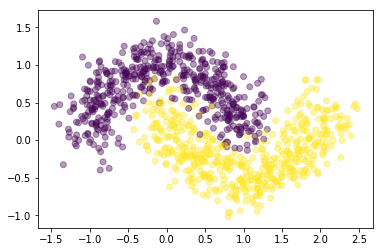

In [5]:
x, y = make_moons(n_samples=1000, shuffle=True, noise=0.2, random_state=32)
x_trn, x_tst, y_trn, y_tst = train_test_split(x, y, train_size=0.7)
x_dev, x_tst, y_dev, y_tst = train_test_split(x_tst, y_tst, train_size=0.69)

x_trn = torch.from_numpy(x_trn).to(torch.float)
x_dev = torch.from_numpy(x_dev).to(torch.float)
y_trn = torch.from_numpy(y_trn).to(torch.long)
y_dev = torch.from_numpy(y_dev).to(torch.long)

print('Trn {} / {}'.format(len(x_trn), len(x_trn) / len(x)))
print('Dev {} / {}'.format(len(x_dev), len(x_dev) / len(x)))
print('Tst {} / {}'.format(len(x_tst), len(x_tst) / len(x)))

plt.scatter(*x.T, c=y, alpha=0.4)
plt.show()

In [23]:
METAHEURISTIC = 'firefly'
DEST_FOLDER = Path('./trained/')
callno = 0

def fun(x: np.ndarray):
    global callno

    hidden1 = int(np.round(x[0][0]))
    hidden2 = int(np.round(x[1][0]))
    lr = x[2][0]
    
    model_name = f'{METAHEURISTIC}_{callno}'
    filename = str(DEST_FOLDER / model_name)

    cbs = [
        callbacks.Checkpoint('val_accuracy', min_delta=1e-3, filename=filename, save_best=True, increasing=True)
    ]

    model = SimpleNet(n_fts=2, n_classes=2, hidden1=hidden1, hidden2=hidden2)
    loss_fn = F.cross_entropy
    nn_optimizer = topt.SGD(model.parameters(), lr=lr)
    
    history = trainer.train(model, x_trn, y_trn, loss_fn, nn_optimizer,
                            n_epochs=15, batch_size=32, x_val=x_dev, y_val=y_dev,
                            batch_first=True, callbacks=cbs, verbosity=1)
    
    best_model = torch.load(filename + '.pth')
    eval_metrics = trainer.evaluate(model, x_dev, y_dev, loss_fn, batch_size=32, batch_first=True)
    
    callno += 1
    return 1 - eval_metrics['accuracy']

N_AGENTS = 20
lower_bound = [3, 1, 0.001]
upper_bound = [150, 150, 0.1]
hp = dict(alpha=0.5, beta=0.2, gamma=1.0)
history = utils.optimize(FA,
                         target=fun,
                         n_agents=N_AGENTS,
                         n_variables=3,
                         n_iterations=10,
                         lb=lower_bound,
                         ub=upper_bound,
                         hyperparams=hp)

2019-07-26 10:53:25,252 - opytimizer.spaces.search — INFO — Overriding class: Space -> SearchSpace.
2019-07-26 10:53:25,253 - opytimizer.core.space — DEBUG — Running private method: build().
2019-07-26 10:53:25,255 - opytimizer.core.space — DEBUG — Running private method: check_bound_size().
2019-07-26 10:53:25,256 - opytimizer.core.space — DEBUG — Bound checked.
2019-07-26 10:53:25,258 - opytimizer.core.space — DEBUG — Running private method: check_bound_size().
2019-07-26 10:53:25,260 - opytimizer.core.space — DEBUG — Bound checked.
2019-07-26 10:53:25,263 - opytimizer.core.space — DEBUG — Running private method: create_agents().
2019-07-26 10:53:25,270 - opytimizer.core.space — DEBUG — Agents: 20 | Size: (3, 1) | Iterations: 10 | Lower Bound: [3, 1, 0.001] | Upper Bound: [150, 150, 0.1] | Built: True.
2019-07-26 10:53:25,270 - opytimizer.spaces.search — DEBUG — Running private method: initialize_agents().
2019-07-26 10:53:25,272 - opytimizer.spaces.search — DEBUG — Agents initialize


2019-07-26 10:54:04,764 - opytimizer.optimizers.fa — INFO — Iteration 1/10



2019-07-26 10:54:31,516 - opytimizer.optimizers.fa — INFO — Fitness: 0.06310679611650483
2019-07-26 10:54:31,518 - opytimizer.optimizers.fa — INFO — Position: [[1.43743885e+02]
 [2.68080580e+01]
 [9.48189450e-02]]
2019-07-26 10:54:31,520 - opytimizer.optimizers.fa — INFO — Iteration 2/10



2019-07-26 10:54:55,011 - opytimizer.optimizers.fa — INFO — Fitness: 0.06310679611650483
2019-07-26 10:54:55,012 - opytimizer.optimizers.fa — INFO — Position: [[1.43743885e+02]
 [2.68080580e+01]
 [9.48189450e-02]]
2019-07-26 10:54:55,013 - opytimizer.optimizers.fa — INFO — Iteration 3/10



2019-07-26 10:55:22,432 - opytimizer.optimizers.fa — INFO — Fitness: 0.06310679611650483
2019-07-26 10:55:22,435 - opytimizer.optimizers.fa — INFO — Position: [[1.43743885e+02]
 [2.68080580e+01]
 [9.48189450e-02]]
2019-07-26 10:55:22,437 - opytimizer.optimizers.fa — INFO — Iteration 4/10



2019-07-26 10:55:49,420 - opytimizer.optimizers.fa — INFO — Fitness: 0.058252427184465994
2019-07-26 10:55:49,422 - opytimizer.optimizers.fa — INFO — Position: [[1.43743885e+02]
 [2.68080580e+01]
 [9.48189450e-02]]
2019-07-26 10:55:49,424 - opytimizer.optimizers.fa — INFO — Iteration 5/10



2019-07-26 10:56:15,171 - opytimizer.optimizers.fa — INFO — Fitness: 0.058252427184465994
2019-07-26 10:56:15,176 - opytimizer.optimizers.fa — INFO — Position: [[1.43743885e+02]
 [2.68080580e+01]
 [9.48189450e-02]]
2019-07-26 10:56:15,177 - opytimizer.optimizers.fa — INFO — Iteration 6/10



2019-07-26 10:56:42,232 - opytimizer.optimizers.fa — INFO — Fitness: 0.058252427184465994
2019-07-26 10:56:42,234 - opytimizer.optimizers.fa — INFO — Position: [[1.43743885e+02]
 [2.68080580e+01]
 [9.48189450e-02]]
2019-07-26 10:56:42,236 - opytimizer.optimizers.fa — INFO — Iteration 7/10



2019-07-26 10:57:07,606 - opytimizer.optimizers.fa — INFO — Fitness: 0.058252427184465994
2019-07-26 10:57:07,609 - opytimizer.optimizers.fa — INFO — Position: [[1.43743885e+02]
 [2.68080580e+01]
 [9.48189450e-02]]
2019-07-26 10:57:07,611 - opytimizer.optimizers.fa — INFO — Iteration 8/10



2019-07-26 10:57:34,069 - opytimizer.optimizers.fa — INFO — Fitness: 0.058252427184465994
2019-07-26 10:57:34,072 - opytimizer.optimizers.fa — INFO — Position: [[1.43743885e+02]
 [2.68080580e+01]
 [9.48189450e-02]]
2019-07-26 10:57:34,074 - opytimizer.optimizers.fa — INFO — Iteration 9/10



2019-07-26 10:57:57,830 - opytimizer.optimizers.fa — INFO — Fitness: 0.058252427184465994
2019-07-26 10:57:57,832 - opytimizer.optimizers.fa — INFO — Position: [[1.43743885e+02]
 [2.68080580e+01]
 [9.48189450e-02]]
2019-07-26 10:57:57,834 - opytimizer.optimizers.fa — INFO — Iteration 10/10



2019-07-26 10:58:23,881 - opytimizer.optimizers.fa — INFO — Fitness: 0.058252427184465994
2019-07-26 10:58:23,883 - opytimizer.optimizers.fa — INFO — Position: [[1.43743885e+02]
 [2.68080580e+01]
 [9.48189450e-02]]
2019-07-26 10:58:23,884 - opytimizer.opytimizer — INFO — Optimization task ended.
2019-07-26 10:58:23,886 - opytimizer.opytimizer — INFO — It took 298.6002058982849 seconds.


In [24]:
utils.get_top_models(history, N_AGENTS)

[(17, 17, 0.06310679611650483), (17, 77, 0.058252427184465994)]